- **This code computes the CLDRTO solution using a scenario-based stochastic programming approach**
- The underlying control structure (modeled in the CLDRTO model) is an MPC, which can is solved using three different strategies: 1. unconstrained, 2. constrained using binaries, and 3. constrained using MPCC
- The problem is posed as a scenario-based stochastic programming problem
- The problem is solved using a monolithic structure, i.e. independently of the number of scenarios or reactors in parallel, everything is solved at once.
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, CSV, DataFrames

# Bioreactor Model

$0 = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$0 = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$
- Specified parameters: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\]

By rearranging the equations above and replacing the specified parameter values, we obtain an analytical expression for the steady state values as a function of $C_{in}$:

$C =\dfrac{C_{in} - 1.2 \pm ((C_{in} - 1.2)^2 + 0.8C_{in})^{0.5}}{2} $ <br>
$P = \dfrac{C}{(0.2 + C)}$ <br>

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [2]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

# nominal models
nNom = 50

A = Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])
B = bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3]
C = 1;

# Simulation

In [3]:
# number of evaluation points 
ns = 100

# creating input array array
Cin_array = LinRange(0.3,3.0, ns)

# values for plotting
C_array = Matrix{Float64}(undef,2,ns)
P_array = Matrix{Float64}(undef,2,ns)

for ii in 1:ns
    # current iteration Cin value
    Cin_i = Cin_array[ii]
    
    #############
    # NONLINEAR #
    #############
    # Computing C based on the current Cin value
    C_i_p = (Cin_i - 1.2 +sqrt((Cin_i - 1.2)^2 + 0.8*Cin_i))/2
    C_i_m = (Cin_i - 1.2 +sqrt((Cin_i - 1.2)^2 + 0.8*Cin_i))/2
    
    # choosing the positive root
    C_i = maximum([C_i_p,C_i_m])
    
    # Computing P
    P_i = C_i/(0.2 + C_i)
    
    # saving
    C_array[1,ii] = C_i
    P_array[1,ii] = P_i
        
    ##########
    # LINEAR #
    ##########
    x_ss = (I(2) - A)\(B*(Cin_i - u0))
    
    #extracting states
    C_i_l = x_ss[1] + x0[1]
    P_i_l = x_ss[2] + x0[2]
    
    # saving
    C_array[2,ii] = C_i_l
    P_array[2,ii] = P_i_l
        
end;

Plotting values

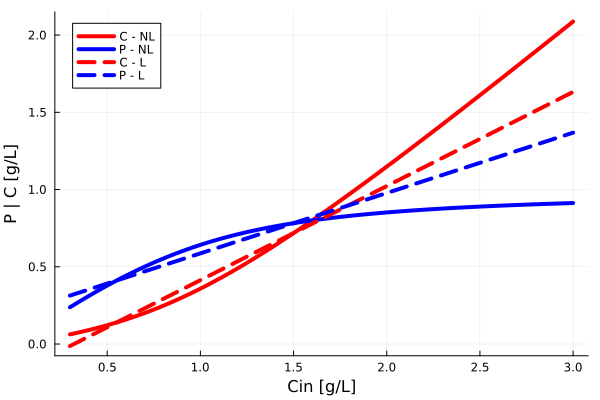

In [4]:
gr()

p1 = plot(xlabel = "Cin [g/L]",ylabel = "P | C [g/L]",legend=:topleft)

p1 = plot!(Cin_array,C_array[1,:], linestyle = :solid, linecolor = :red,linewidth = 4,)
p1 = plot!(Cin_array,P_array[1,:], linestyle = :solid, linecolor = :blue,linewidth = 4)
p1 = plot!(Cin_array,C_array[2,:], linestyle = :dash, linecolor = :red,linewidth = 4)
p1 = plot!(Cin_array,P_array[2,:], linestyle = :dash, linecolor = :blue,linewidth = 4)

p1.series_list[1][:label] = "C - NL"
p1.series_list[2][:label] = "P - NL"
p1.series_list[3][:label] = "C - L"
p1.series_list[4][:label] = "P - L"

display(p1)

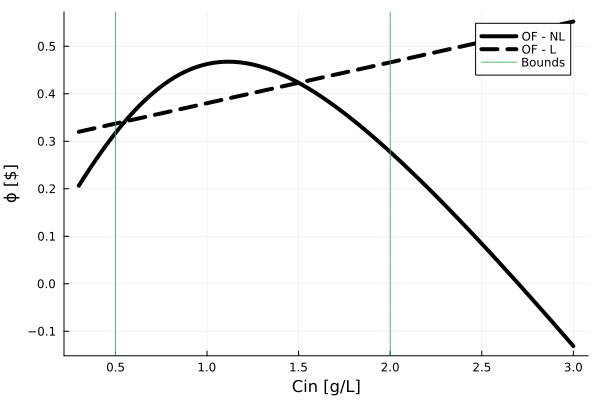

In [5]:
gr()

p2 = plot(xlabel = "Cin [g/L]",ylabel = "ϕ [\$]",legend=:topright)

p2 = plot!(Cin_array,P_array[1,:] - 0.5*C_array[1,:], linestyle = :solid, linecolor = :black, linewidth = 4)
p2 = plot!(Cin_array,P_array[2,:] - 0.5*C_array[2,:], linestyle = :dash, linecolor = :black, linewidth = 4)
p2 = vline!([0.5,2.0],linestyle = :dot)

p2.series_list[1][:label] = "OF - NL"
p2.series_list[2][:label] = "OF - L"
p2.series_list[3][:label] = "Bounds"

display(p2)